# Model Evaluation and Optimization Demo

This notebook demonstrates the process of evaluating and optimizing the transaction failure prediction models.

In [2]:
import sys, os
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.insert(0, project_root)

# Import our modules
from src.model.data_processor import load_transaction_data, preprocess_data, prepare_features_target, split_data, scale_features
from src.model.model_trainer import ModelTrainer
from src.model.model_evaluation import ModelEvaluator, ModelOptimizer
from src.simulator.transaction_simulator import TransactionSimulator

import matplotlib.pyplot as plt
import seaborn as sns

## Load and Prepare Data

Load the combined transaction data and prepare it for model evaluation.

In [4]:
# Check if combined data exists, otherwise generate sample data
data_path = 'data/combined_transaction_data.csv'

if os.path.exists(data_path):
    print(f"Loading data from {data_path}")
    df = load_transaction_data(data_path)
else:
    print("Combined data not found, generating sample data...")
    
    # Generate sample data
    simulator = TransactionSimulator(failure_rate=0.15)
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
    
    df = simulator.generate_transactions(
        count=5000,
        start_date=start_date,
        end_date=end_date
    )
    
    # Save for future use
    os.makedirs('data', exist_ok=True)
    df.to_csv(data_path, index=False)
    print(f"Sample data generated and saved to {data_path}")

print(f"Loaded {len(df)} transactions")
print(f"Failure rate: {df['transaction_failure'].mean():.2%}")
df.head()

INFO:src.model.data_processor:Successfully loaded 5000 transactions from data/combined_transaction_data.csv


Loading data from data/combined_transaction_data.csv
Loaded 5000 transactions
Failure rate: 17.76%


,transaction_id,timestamp,transaction_amount,time_of_day,day_of_week,transaction_type,location,account_balance,historical_failure_rate,merchant_category,location_risk_score,transaction_failure,failure_type,failure_reason
0,6bf583d6-27d0-4f58-901f-cf8ed00e7326,2023-05-01 13:42:20,35.539449,13,0,credit,local,29.117065,0.135339,retail,0.222490,1,timeout,timeout
1,a5d2e11a-9bba-4cf0-9924-b4ae4b520c3c,2023-02-07 08:14:41,166.198257,8,1,credit,high_risk_location_2,49.885930,0.140073,online,0.888854,0,success,none
2,c44f5ca5-f4c9-4a72-82e6-f7b8363a873e,2023-04-11 09:42:17,24.687103,9,1,credit,local,31.711979,0.116185,grocery,0.513578,0,success,none
3,36c2a882-221c-4657-ab8c-c0217e34e32a,2023-08-11 08:36:42,7.601688,8,4,credit,national,69.192577,0.193305,online,0.747171,0,success,none
4,af42e84d-469f-46c6-bc08-bfe41ed813b0,2023-01-20 01:21:59,6.439102,1,4,credit,high_risk_location_1,34.390058,0.355040,other,0.819418,0,success,none


## Preprocess Data and Split into Train/Test Sets

Preprocess the data and split it into training and testing sets.

In [11]:
# Preprocess data
df_processed, label_encoders = preprocess_data(df)
print(f"Processed data shape: {df_processed.shape}")

# Prepare features and target
X, y = prepare_features_target(df_processed, 'transaction_failure')
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale features
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
print("Features scaled successfully")

INFO:src.model.data_processor:Starting data preprocessing...
INFO:src.model.data_processor:Data preprocessing completed
INFO:src.model.data_processor:Data split: 4000 training samples, 1000 testing samples
INFO:src.model.data_processor:Feature scaling completed


Processed data shape: (5000, 14)
Features shape: (5000, 13)
Target shape: (5000,)
Training set: 4000 samples
Testing set: 1000 samples
Features scaled successfully


## Train Models for Evaluation

Train the models that will be evaluated and optimized.

In [6]:
# Initialize and train models
trainer = ModelTrainer()
trainer.train_models(X_train_scaled, y_train)
print("Models trained successfully")

INFO:src.model.model_trainer:Starting model training...
INFO:src.model.model_trainer:Training logistic_regression...
INFO:src.model.model_trainer:Completed training logistic_regression
INFO:src.model.model_trainer:Training random_forest...
INFO:src.model.model_trainer:Completed training random_forest
INFO:src.model.model_trainer:Training naive_bayes...
INFO:src.model.model_trainer:Completed training naive_bayes


Models trained successfully


## Evaluate Models

Evaluate the performance of all trained models using the ModelEvaluator.

In [12]:
# Initialize evaluator
evaluator = ModelEvaluator()

# Evaluate each model
model_results = []
for model_name, model in trainer.trained_models.items():
    result = evaluator.evaluate_model(model, X_test_scaled, y_test, model_name)
    model_results.append(result)

# Compare models
comparison_df = evaluator.compare_models(model_results)
print("Model Comparison:")
print(comparison_df)

INFO:src.model.model_evaluation:Evaluating logistic_regression...
INFO:src.model.model_evaluation:logistic_regression - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, ROC AUC: 1.0000
INFO:src.model.model_evaluation:Evaluating random_forest...
INFO:src.model.model_evaluation:random_forest - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, ROC AUC: 1.0000
INFO:src.model.model_evaluation:Evaluating naive_bayes...
INFO:src.model.model_evaluation:naive_bayes - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, ROC AUC: 1.0000


Model Comparison:
                 Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
0  logistic_regression       1.0        1.0     1.0       1.0      1.0
1        random_forest       1.0        1.0     1.0       1.0      1.0
2          naive_bayes       1.0        1.0     1.0       1.0      1.0


## Visualize Model Performance

Create visualizations to compare model performance.

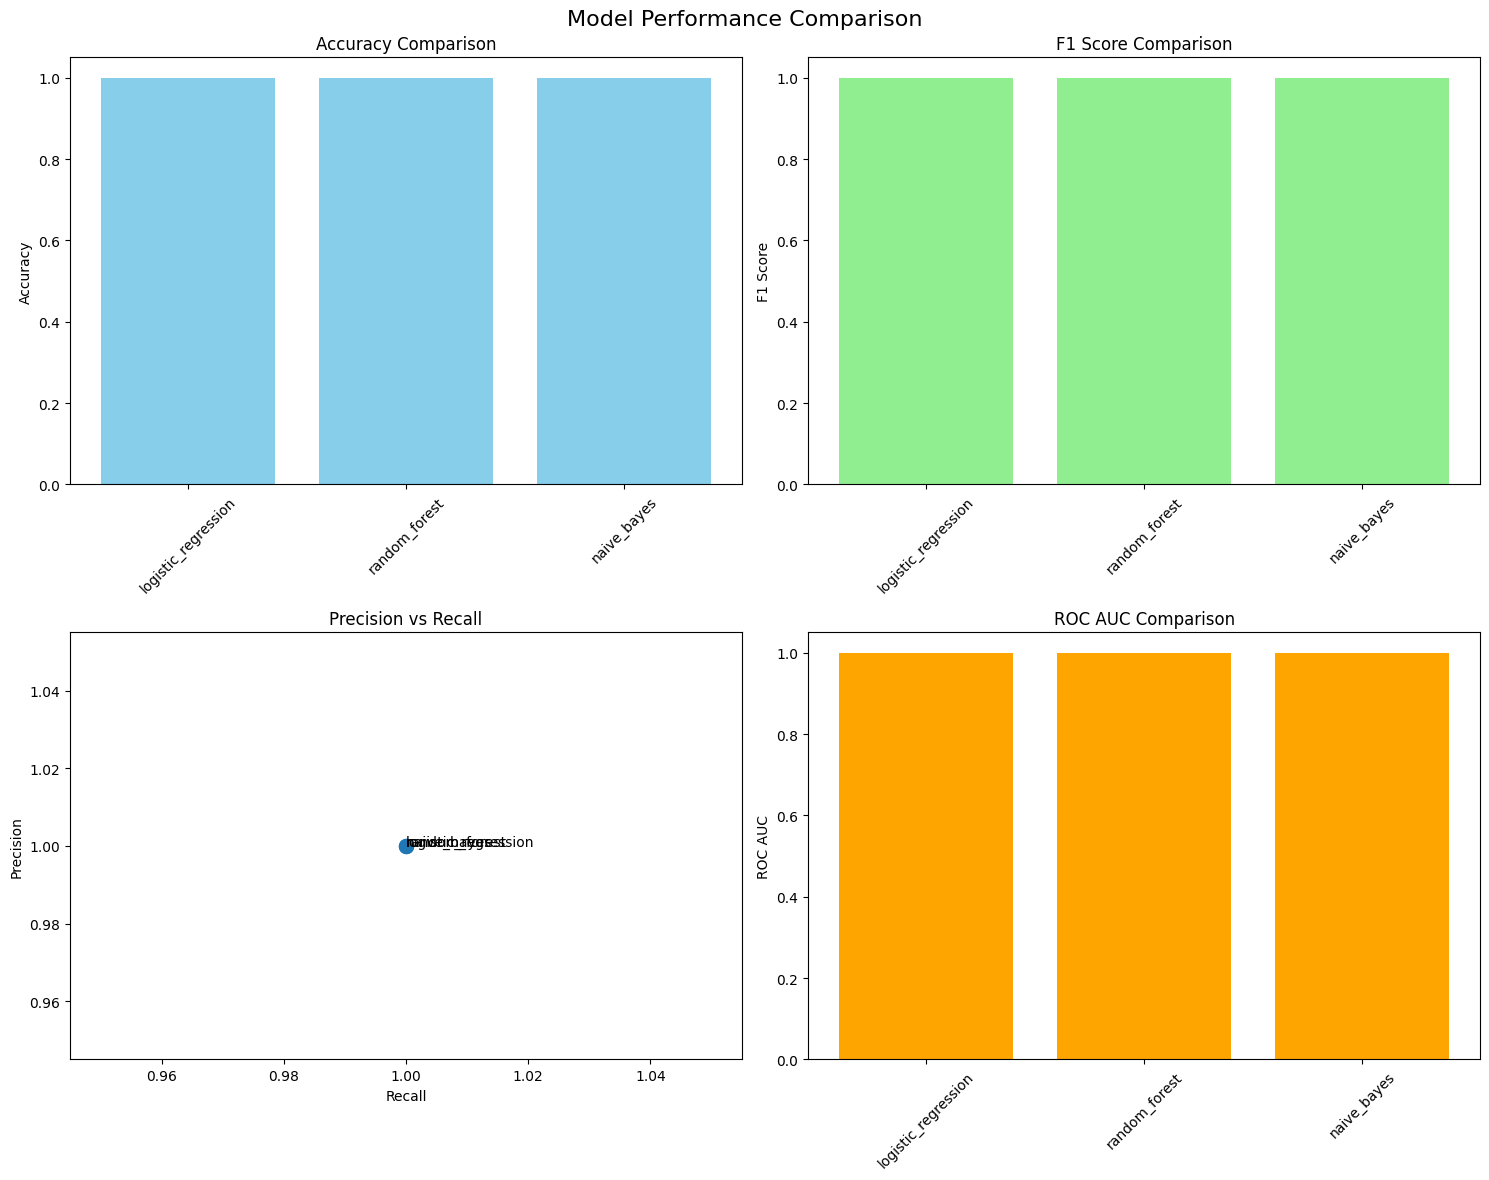

In [8]:
# Create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot 1: Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: F1 Score comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['F1_Score'], color='lightgreen')
axes[0, 1].set_title('F1 Score Comparison')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Precision vs Recall
axes[1, 0].scatter(comparison_df['Recall'], comparison_df['Precision'], s=100)
for i, txt in enumerate(comparison_df['Model']):
    axes[1, 0].annotate(txt, (comparison_df['Recall'].iloc[i], comparison_df['Precision'].iloc[i]))
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')

# Plot 4: ROC AUC comparison
if comparison_df['ROC_AUC'].notna().any():
    axes[1, 1].bar(comparison_df['Model'], comparison_df['ROC_AUC'], color='orange')
    axes[1, 1].set_title('ROC AUC Comparison')
    axes[1, 1].set_ylabel('ROC AUC')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'ROC AUC not available', horizontalalignment='center', 
                     verticalalignment='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('ROC AUC Comparison')

plt.tight_layout()
plt.show()

## Perform Cross-Validation

Perform cross-validation on the best performing model.

In [13]:
# Identify the best model based on F1 score
best_model_name = comparison_df.iloc[0]['Model']
best_model = trainer.trained_models[best_model_name]

print(f"Performing cross-validation on the best model: {best_model_name}")

# Perform cross-validation
cv_results = evaluator.cross_validate_model(best_model, X_train_scaled, y_train, cv=5)

# Print cross-validation results
for metric, result in cv_results.items():
    print(f"{metric}: {result['mean']:.4f} (+/- {result['std'] * 2:.4f})")

INFO:src.model.model_evaluation:Performing 5-fold cross-validation...
INFO:src.model.model_evaluation:accuracy: 1.0000 (+/- 0.0000)


Performing cross-validation on the best model: logistic_regression


INFO:src.model.model_evaluation:precision: 1.0000 (+/- 0.0000)
INFO:src.model.model_evaluation:recall: 1.0000 (+/- 0.0000)
INFO:src.model.model_evaluation:f1: 1.0000 (+/- 0.0000)
INFO:src.model.model_evaluation:roc_auc: 1.0000 (+/- 0.0000)


accuracy: 1.0000 (+/- 0.0000)
precision: 1.0000 (+/- 0.0000)
recall: 1.0000 (+/- 0.0000)
f1: 1.0000 (+/- 0.0000)
roc_auc: 1.0000 (+/- 0.0000)


## Optimize Model Hyperparameters

Use the ModelOptimizer to find better hyperparameters for the models.

In [10]:
# Initialize optimizer
optimizer = ModelOptimizer()

# Optimize Random Forest
print("Optimizing Random Forest...")
rf_model, rf_params, rf_score = optimizer.optimize_random_forest(
    X_train_scaled, y_train, n_iter=20, cv=3  # Reduced for demo speed
)

# Evaluate the optimized Random Forest
optimized_rf_result = evaluator.evaluate_model(rf_model, X_test_scaled, y_test, 'optimized_random_forest')

# If Logistic Regression is the best model, optimize it too
if 'logistic_regression' in trainer.trained_models:
    print("Optimizing Logistic Regression...")
    lr_model, lr_params, lr_score = optimizer.optimize_logistic_regression(
        X_train_scaled, y_train, cv=3  # Reduced for demo speed
    )
    
    # Evaluate the optimized Logistic Regression
    optimized_lr_result = evaluator.evaluate_model(lr_model, X_test_scaled, y_test, 'optimized_logistic_regression')

INFO:src.model.model_evaluation:Starting Random Forest hyperparameter optimization...


Optimizing Random Forest...


d:\Python\PythonFiles\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\PythonFiles\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python\PythonFiles\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "d:\Python\PythonFiles\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "d:\Python\PythonFiles\Lib\site-packages\sklearn\utils\_

Optimizing Logistic Regression...


TypeError: Parameter grid for parameter 'C' needs to be a list or a numpy array, but got 0.001 (of type float) instead. Single values need to be wrapped in a list with one element.

## Compare Original vs Optimized Models

Compare the performance of original and optimized models.

Comparison of Original and Optimized Models:
                     Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
0      logistic_regression       1.0        1.0     1.0       1.0      1.0
1            random_forest       1.0        1.0     1.0       1.0      1.0
2              naive_bayes       1.0        1.0     1.0       1.0      1.0
3  optimized_random_forest       1.0        1.0     1.0       1.0      1.0


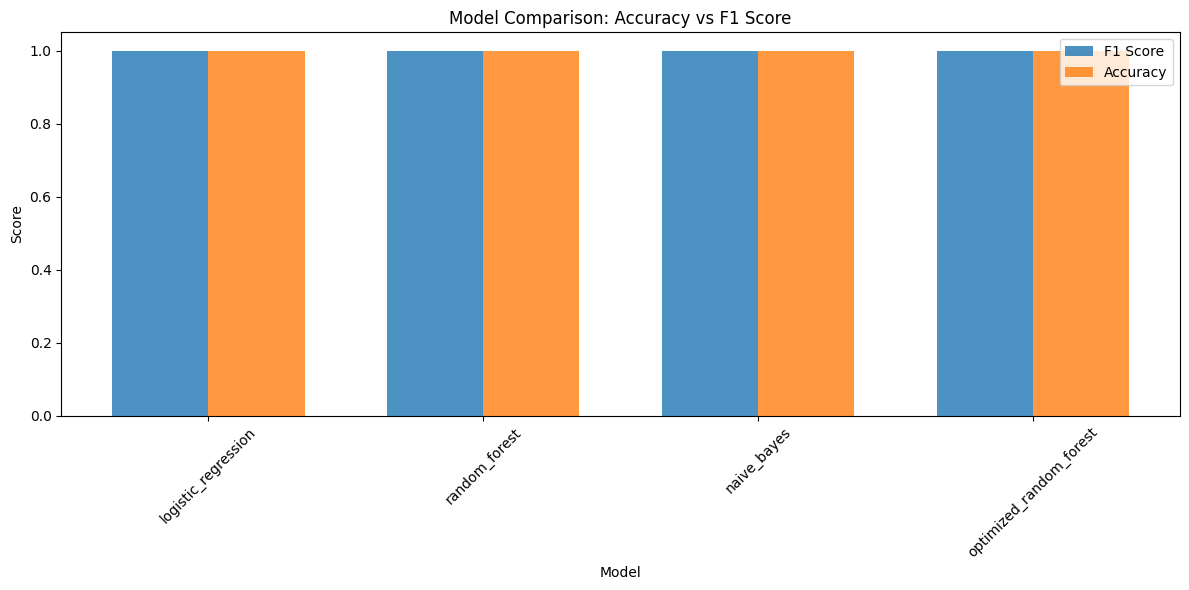

In [14]:
# Collect all results (original and optimized)
all_results = model_results.copy()

# Add optimized results if they exist
if 'optimized_rf_result' in locals():
    all_results.append(optimized_rf_result)
if 'optimized_lr_result' in locals():
    all_results.append(optimized_lr_result)

# Compare all models
all_comparison_df = evaluator.compare_models(all_results)
print("Comparison of Original and Optimized Models:")
print(all_comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(all_comparison_df))
width = 0.35

plt.bar(x - width/2, all_comparison_df['F1_Score'], width, label='F1 Score', alpha=0.8)
plt.bar(x + width/2, all_comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs F1 Score')
plt.xticks(x, all_comparison_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Save the Best Optimized Model

Save the best performing optimized model for later use.

In [15]:
# Find the best optimized model based on F1 score
best_optimized_model_name = all_comparison_df.iloc[0]['Model']

# Get the corresponding model from optimizer
if 'optimized_random_forest' in best_optimized_model_name:
    best_optimized_model = optimizer.best_models['random_forest']
elif 'optimized_logistic_regression' in best_optimized_model_name:
    best_optimized_model = optimizer.best_models['logistic_regression']
else:
    # If it's not an optimized model, get from original trainer
    best_optimized_model = trainer.trained_models[best_optimized_model_name]

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best optimized model
model_path = f'models/best_optimized_transaction_model_{best_optimized_model_name.replace(" ", "_")}.pkl'
import joblib
joblib.dump(best_optimized_model, model_path)
print(f"Best optimized model ({best_optimized_model_name}) saved to {model_path}")

# Also save the scaler for use with the model
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoders if they exist
if label_encoders:
    encoders_path = 'models/label_encoders.pkl'
    joblib.dump(label_encoders, encoders_path)
    print(f"Label encoders saved to {encoders_path}")

Best optimized model (logistic_regression) saved to models/best_optimized_transaction_model_logistic_regression.pkl
Scaler saved to models/scaler.pkl
Label encoders saved to models/label_encoders.pkl


## Summary

We have successfully completed the model evaluation and optimization process:
1. Loaded and prepared the transaction data
2. Trained multiple models (Logistic Regression, Random Forest, Naive Bayes)
3. Evaluated all models using multiple metrics (accuracy, precision, recall, F1, ROC AUC)
4. Performed cross-validation on the best model
5. Optimized hyperparameters for Random Forest and Logistic Regression
6. Compared original and optimized models
7. Saved the best performing optimized model

The optimization process helps improve model performance by finding better hyperparameters for the models.